In [0]:
from IPython.display import display
import numpy as np
# import modin.pandas as pd
import pandas as pd
import datetime
import time
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE, f_regression

import itertools

import warnings
import json

warnings.filterwarnings('ignore')

plt.style.use("fivethirtyeight")
sns.set_style({'font.sans-serif': ['simsun', 'Arial']})
sns.set_style('darkgrid', {'font.sans-serif': ['simhei', 'Arial']})
%matplotlib inline

# np.random.seed(4590)
nf_data_path = r'./noFinacialFeatures.csv'
f_data_path = r'./FinacialFeatures.csv'

flevel = json.load(open(r'./feature_level.json'))

In [0]:
nf_df = pd.read_csv(nf_data_path)
f_df = pd.read_csv(f_data_path)

In [0]:
df = pd.DataFrame()
df = nf_df.copy()
f_df.drop(['企业总评分'], axis=1, inplace=True)
df = df.merge(f_df, how='left', on='企业编号')

In [0]:
y = df[['企业编号', '企业总评分']]
x = df.drop(['企业总评分'], axis=1)

In [0]:
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=0)
ytrain_id = ytrain['企业编号']
ytrain = ytrain['企业总评分']
ytest_id = ytest['企业编号']
ytest = ytest['企业总评分']
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

id_train = xtrain['企业编号']
id_test = xtest['企业编号']
xtrain.drop(['企业编号'], axis=1, inplace=True)
xtest.drop(['企业编号'], axis=1, inplace=True)

(2364, 307) (592, 307) (2364,) (592,)


In [0]:
def print_(gs):
    print(gs.cv_results_)
    print(gs.best_params_)
    print(gs.best_score_)
    print('rmse:', np.sqrt(np.abs(gs.best_score_)))

# 调参

## 学习率和估计器及其数目

In [0]:
params = {'boosting_type': 'gbdt',
          'objective': 'regression',

          'learning_rate': 0.001,
          'num_leaves': 110,
          'max_depth': 7,

          'subsample': 0.8,
          'colsample_bytree': 0.8,
          "metric": 'rmse', }

In [0]:
data_train = lgb.Dataset(xtrain, ytrain, silent=True)
cv_results = lgb.cv(
    params, data_train, num_boost_round=10000, nfold=5, stratified=False, shuffle=True, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=50, show_stdv=True, seed=0)

print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])

[50]	cv_agg's rmse: 4.94681 + 0.159085
[100]	cv_agg's rmse: 4.82183 + 0.160349
[150]	cv_agg's rmse: 4.70485 + 0.161866
[200]	cv_agg's rmse: 4.59534 + 0.163504
[250]	cv_agg's rmse: 4.49212 + 0.165191
[300]	cv_agg's rmse: 4.39565 + 0.166612
[350]	cv_agg's rmse: 4.30632 + 0.167825
[400]	cv_agg's rmse: 4.22476 + 0.169009
[450]	cv_agg's rmse: 4.14814 + 0.169685
[500]	cv_agg's rmse: 4.07666 + 0.169847
[550]	cv_agg's rmse: 4.01103 + 0.170299
[600]	cv_agg's rmse: 3.94945 + 0.170854
[650]	cv_agg's rmse: 3.89271 + 0.171538
[700]	cv_agg's rmse: 3.84102 + 0.172256
[750]	cv_agg's rmse: 3.79258 + 0.17284
[800]	cv_agg's rmse: 3.74763 + 0.173087
[850]	cv_agg's rmse: 3.7063 + 0.173007
[900]	cv_agg's rmse: 3.66813 + 0.173361
[950]	cv_agg's rmse: 3.63244 + 0.172179
[1000]	cv_agg's rmse: 3.59988 + 0.171469
[1050]	cv_agg's rmse: 3.56919 + 0.170973
[1100]	cv_agg's rmse: 3.54149 + 0.170208
[1150]	cv_agg's rmse: 3.516 + 0.169106
[1200]	cv_agg's rmse: 3.49263 + 0.168392
[1250]	cv_agg's rmse: 3.47044 + 0.167392

## max_depth 和 num_leaves

In [0]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=50,
                              learning_rate=0.1, n_estimators=43, max_depth=6,
                              metric='rmse', bagging_fraction=0.8, feature_fraction=0.8)

params_test1 = {
    'max_depth': range(3, 8, 2),
    'num_leaves': range(20, 100, 30)
}
gsearch1 = GridSearchCV(estimator=model_lgb, param_grid=params_test1,
                        scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=2)
gsearch1.fit(xtrain, ytrain)
# print(gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_)
# print('rmse:', np.sqrt(np.abs(gsearch1.best_score_)))
print_(gsearch1)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   32.9s
[Parallel(n_jobs=2)]: Done  90 out of  90 | elapsed:  1.4min finished


{'mean_fit_time': array([0.92085559, 0.95250058, 0.81514375, 1.7938025 , 1.6340225 ,
       1.4990643 , 1.79567962, 2.53424389, 2.49483378]), 'std_fit_time': array([0.00707319, 0.048489  , 0.1618288 , 0.20759863, 0.29997807,
       0.26141865, 0.29782629, 0.54207498, 0.4510752 ]), 'mean_score_time': array([0.10262785, 0.09872396, 0.07656128, 0.09280767, 0.07676151,
       0.0744283 , 0.078845  , 0.07643392, 0.07436543]), 'std_score_time': array([0.00187215, 0.01305794, 0.01944329, 0.01111545, 0.01643953,
       0.01687405, 0.02342747, 0.01855839, 0.01470031]), 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object), 'param_num_leaves': masked_array(data=[20, 50, 80, 20, 50, 80, 20, 50, 80],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dt

In [0]:
params_test2 = {
    'max_depth': [4, 5, 6],
    'num_leaves': [14, 16, 18, 20, 22, 24]
}

gsearch2 = GridSearchCV(estimator=model_lgb, param_grid=params_test2,
                        scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=2)
gsearch2.fit(xtrain, ytrain)
print(gsearch2.cv_results_)
print(gsearch2.best_params_)
print(gsearch2.best_score_)
print('rmse:', np.sqrt(np.abs(gsearch2.best_score_)))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   30.3s
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:  2.6min finished


{'mean_fit_time': array([1.36653383, 1.09408345, 1.03487799, 1.03452284, 1.07209079,
       1.03925378, 1.26209984, 1.32340829, 1.38175254, 1.73965721,
       1.89382095, 1.86431124, 1.78585267, 1.89364927, 1.93473694,
       1.71859808, 1.77160425, 2.18911905]), 'std_fit_time': array([0.04607406, 0.21578606, 0.17471289, 0.18349589, 0.18418632,
       0.18045577, 0.22674089, 0.23940779, 0.25423431, 0.25700037,
       0.07969668, 0.04767033, 0.01752817, 0.03163411, 0.28548189,
       0.36152996, 0.31908205, 0.48044758]), 'mean_score_time': array([0.10029099, 0.07462955, 0.07196858, 0.07183502, 0.07426641,
       0.07207785, 0.07141411, 0.07167449, 0.07225733, 0.09043505,
       0.09697895, 0.09515953, 0.09257777, 0.09314201, 0.09124854,
       0.07639015, 0.0793395 , 0.08808327]), 'std_score_time': array([0.01312466, 0.01736638, 0.0132277 , 0.01328873, 0.01367796,
       0.01359791, 0.0135743 , 0.01354999, 0.01431537, 0.01352738,
       0.00437607, 0.00464146, 0.00053888, 0.00126583, 0.

## min_data_in_leaf 和 min_sum_hessian_in_leaf

In [0]:
params_test3 = {
    'min_data_in_leaf': [18, 19, 20, 21, 22],
    'min_sum_hessian_in_leaf': [0.001, 0.002]
}
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=100,
                              learning_rate=0.1, n_estimators=941, max_depth=7,
                              metric='rmse', bagging_fraction=0.7, feature_fraction=0.8)
gsearch3 = GridSearchCV(estimator=model_lgb, param_grid=params_test3,
                        scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=8)
gsearch3.fit(xtrain, ytrain)
print_(gsearch3)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.


KeyboardInterrupt: ignored

## feature_fraction 和 bagging_fraction

In [0]:
params_test4 = {
    'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9],
    'bagging_fraction': [0.6, 0.7, 0.8, 0.9, 1.0]
}
model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=16,
                              learning_rate=0.1,
                              n_estimators=43,
                              max_depth=6,
                              metric='rmse',
                              bagging_freq=5,
                              min_child_samples=20,
                              min_child_weight=0.001)
gsearch4 = GridSearchCV(estimator=model_lgb, param_grid=params_test4,
                        scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=4)
gsearch4.fit(xtrain, ytrain)
print_(gsearch4)

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   25.6s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.0min
[Parallel(n_jobs=4)]: Done 250 out of 250 | elapsed:  2.6min finished


{'mean_fit_time': array([1.52890165, 1.68892879, 1.99096341, 2.45279725, 2.96322303,
       1.53853116, 1.81281204, 1.9841588 , 2.50049465, 2.72619491,
       1.80894279, 2.02389319, 2.2905458 , 2.38861339, 2.62607818,
       1.72504992, 1.91050556, 2.28192964, 2.60278957, 2.64744437,
       1.66610479, 2.00411994, 2.25824735, 2.47829208, 2.62041569]), 'std_fit_time': array([0.1440184 , 0.13613726, 0.13121932, 0.31410123, 0.52506249,
       0.24742629, 0.16123335, 0.18808681, 0.20924647, 0.20986292,
       0.21038671, 0.2015985 , 0.21959279, 0.14541002, 0.16114324,
       0.12275598, 0.10543616, 0.1872898 , 0.1722875 , 0.07166341,
       0.15272759, 0.18114585, 0.16659856, 0.17745014, 0.22466804]), 'mean_score_time': array([0.12549422, 0.10039601, 0.10719349, 0.14675357, 0.14070678,
       0.1203696 , 0.13885729, 0.11928558, 0.13347023, 0.14235203,
       0.14960563, 0.13403726, 0.15306253, 0.12587166, 0.11638017,
       0.12471328, 0.12208233, 0.1329752 , 0.12285206, 0.12949545,
     

## 正则化参数

In [0]:
params_test6 = {
    'reg_alpha': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5],
    'reg_lambda': [0, 0.001, 0.01, 0.03, 0.08, 0.3, 0.5]
}
model_lgb = lgb.LGBMRegressor(objective='regression',
                              num_leaves=16,
                              learning_rate=0.1,
                              n_estimators=43,
                              max_depth=6,
                              metric='rmse',
                              min_child_samples=20,
                              min_child_weight=0.001,
                              feature_fraction=0.8,
                              bagging_fraction=0.7)
gsearch6 = GridSearchCV(estimator=model_lgb, param_grid=params_test6,
                        scoring='neg_mean_squared_error', cv=10, verbose=1, n_jobs=4)
gsearch6.fit(xtrain, ytrain)
print_(gsearch6)

Fitting 10 folds for each of 49 candidates, totalling 490 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   30.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  5.4min
[Parallel(n_jobs=4)]: Done 490 out of 490 | elapsed:  6.0min finished


{'mean_fit_time': array([2.54953973, 2.48352652, 2.44470265, 2.40663574, 2.44401784,
       3.07249022, 3.06396115, 2.58210669, 2.4684319 , 2.49551215,
       2.5604156 , 2.50873158, 2.49764013, 2.68728771, 2.49779704,
       2.57869885, 2.59264336, 2.55016713, 2.55847514, 2.60326304,
       2.5180795 , 2.59333334, 2.56451044, 2.54676473, 2.88733516,
       2.73384731, 2.60004342, 2.62316666, 2.47140055, 2.5543318 ,
       2.62194357, 2.62157247, 2.66752541, 2.6159936 , 2.75703018,
       2.63211706, 2.64107139, 2.85074286, 2.56648724, 2.63695562,
       2.6791122 , 2.55771363, 2.59988146, 2.67818027, 2.7400804 ,
       2.78853831, 2.69739177, 2.81976368, 2.52642329]), 'std_fit_time': array([0.15366366, 0.14704099, 0.11413499, 0.07396026, 0.11799336,
       0.58883204, 0.49783955, 0.21547983, 0.12424784, 0.13143344,
       0.18417971, 0.21139881, 0.16976621, 0.19555309, 0.1566916 ,
       0.19838069, 0.09192913, 0.17775724, 0.13742148, 0.16377159,
       0.18933214, 0.20228498, 0.33839

## 降低learning_rate

In [0]:
# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',

#     'learning_rate': 0.005,
#     'num_leaves': 80,
#     'max_depth': 7,
#     'min_data_in_leaf': 20,

#     'subsample': 1,
#     'colsample_bytree': 0.7,
# }

params = {
    'objective': 'regression',
    'num_leaves': 16,
    'learning_rate': 0.005,
#     'n_estimators': 43,
    'max_depth': 6,
    'metric': 'rmse',
    'min_child_samples': 20,
    'min_child_weight': 0.001,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.7
}

data_train = lgb.Dataset(xtrain, ytrain, silent=True)
cv_results = lgb.cv(
    params, data_train, num_boost_round=10000, nfold=10, stratified=False, shuffle=True, metrics='rmse',
    early_stopping_rounds=50, verbose_eval=100, show_stdv=True)

print('best n_estimators:', len(cv_results['rmse-mean']))
print('best cv score:', cv_results['rmse-mean'][-1])

[100]	cv_agg's rmse: 4.12491 + 0.260789
[200]	cv_agg's rmse: 3.64173 + 0.256248
[300]	cv_agg's rmse: 3.40297 + 0.244103
[400]	cv_agg's rmse: 3.28311 + 0.227424
[500]	cv_agg's rmse: 3.21311 + 0.211949
[600]	cv_agg's rmse: 3.17422 + 0.202855
[700]	cv_agg's rmse: 3.1572 + 0.198252
[800]	cv_agg's rmse: 3.14919 + 0.194758
[900]	cv_agg's rmse: 3.14666 + 0.190449
best n_estimators: 941
best cv score: 3.145967142110073


# Cross validation

In [0]:
nfolds = 10
folds = KFold(n_splits=nfolds, shuffle=True, random_state=15)

## Sample

In [0]:
# params = {'num_leaves': 50,
#           'min_data_in_leaf': 30,
#           'objective': 'regression',
#           'max_depth': 6,
#           'learning_rate': 0.1,
#           "min_child_samples": 100,
#           "boosting": "gbdt",
#           "feature_fraction": 0.8,
#           "bagging_freq": 1,
#           "bagging_fraction": 0.7,
#           "bagging_seed": 11,
#           "metric": 'rmse',
#           "lambda_l1": 0.1,
#           "verbosity": -1,
#           "device":'cpu',
#           "n_jobs":4,
#           "n_estimators":941}


params = {'num_leaves': 80,
         'min_data_in_leaf': 10,
         'objective': 'regression',
         'max_depth': 7,
         'learning_rate': 0.005,
         "min_child_samples": 100,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.7,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "n_jobs":8,
         "n_estimators":941}


In [0]:
feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
mvalid = np.zeros(len(xtrain))
mfull = np.zeros(len(xtest))


for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
    print('----')
    print("fold n°{}".format(fold_))

    x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
    x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]

    trn_data = lgb.Dataset(x0, label=y0)
    val_data = lgb.Dataset(x1, label=y1)

    num_round = 10000
    clf = lgb.train(params,
                    trn_data,
                    num_round,
                    valid_sets=[trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds=150)
    
    mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

    feature_importance_df[:, fold_] = clf.feature_importance()

    mfull += clf.predict(xtest,
                         num_iteration=clf.best_iteration) / folds.n_splits
    
    
np.sqrt(mean_squared_error(mfull.astype(int), ytest.astype(int)))

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 1.97346	valid_1's rmse: 3.00919
Did not meet early stopping. Best iteration is:
[941]	training's rmse: 1.40454	valid_1's rmse: 2.98727
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 1.96027	valid_1's rmse: 3.35494
Did not meet early stopping. Best iteration is:
[941]	training's rmse: 1.36978	valid_1's rmse: 3.32063
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 1.96716	valid_1's rmse: 3.08877
Did not meet early stopping. Best iteration is:
[941]	training's rmse: 1.39434	valid_1's rmse: 3.05962
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 1.95053	valid_1's rmse: 3.30398
Did not meet early stopping. Best iteration is:
[941]	training's rmse: 1.37984	valid_1's rmse: 3.22539
----
fold n°4
Training until validation scores don't improve

3.0064682521775197

## Traing with feature level

In [0]:
def train_lgbm(xtrain, ytrain, xtest, ytest, params):
    feature_importance_df = np.zeros((xtrain.shape[1], nfolds))
    mvalid = np.zeros(len(xtrain))
    mfull = np.zeros(len(xtest))
    models = []


    for fold_, (trn_idx, val_idx) in enumerate(folds.split(xtrain.values, ytrain.values)):
        print('----')
        print("fold n°{}".format(fold_))

        x0, y0 = xtrain.iloc[trn_idx], ytrain.iloc[trn_idx]
        x1, y1 = xtrain.iloc[val_idx], ytrain.iloc[val_idx]

        trn_data = lgb.Dataset(x0, label=y0)
        val_data = lgb.Dataset(x1, label=y1)

        num_round = 10000
        clf = lgb.train(params,
                        trn_data,
                        num_round,
                        valid_sets=[trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=150)

        mvalid[val_idx] = clf.predict(x1, num_iteration=clf.best_iteration)

        feature_importance_df[:, fold_] = clf.feature_importance()

        mfull += clf.predict(xtest,
                             num_iteration=clf.best_iteration) / folds.n_splits
        
        models.append(clf)


    test_error=np.sqrt(mean_squared_error(mfull.astype(int), ytest.astype(int)))
    print()
    print('rmse:', test_error)
    return models, test_error, feature_importance_df

### All features

In [0]:
params_all = {
    # objective and metric
    "objective": "regression",
    "metric": 'rmse',
    "boosting": "gbdt",

    # for the Leaf-wise (Best-first) Tree
    "num_leaves": 100, 
    # smaller than 2^(max_depth), This is the main parameter to control the complexity of the tree model. With larger can get higher accuracy 
    "min_data_in_leaf": 30, # Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.
    "max_depth": 7, # limit the tree depth explicitly.

    # For Faster Speed
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
#     "max_bin": 5, # more small more faster
    "bagging_seed": 11,

    # For Better Accuracy
    "max_bin": 20, # lager but slower
    "learning_rate": 0.005,

    # deal with over fitting
      # Use small max_bin
      # Use small num_leaves
      # Use min_data_in_leaf and min_sum_hessian_in_leaf
      # Use bagging by set bagging_fraction and bagging_freq
      # Use feature sub-sampling by set feature_fraction
      # Use bigger training data
      # Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
      # Try max_depth to avoid growing deep tree
    "feature_fraction": 0.8,
    "lambda_l1": 0.9,

    "min_child_samples": 100,

    # other
    "n_estimators": 1500,
    "verbosity": -1,
    "n_jobs":-1,
}

In [0]:
models, feature_importance_df = train_lgbm(xtrain, ytrain, xtest, ytest, params_all)

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.48445	valid_1's rmse: 2.97748
[1000]	training's rmse: 1.94242	valid_1's rmse: 2.93612
Early stopping, best iteration is:
[892]	training's rmse: 2.03945	valid_1's rmse: 2.92963
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.46543	valid_1's rmse: 3.34328
[1000]	training's rmse: 1.92384	valid_1's rmse: 3.28782
Early stopping, best iteration is:
[999]	training's rmse: 1.92488	valid_1's rmse: 3.28764
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.48863	valid_1's rmse: 3.07938
Early stopping, best iteration is:
[775]	training's rmse: 2.15276	valid_1's rmse: 3.03324
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.47913	valid_1's rmse: 3.30472
[1000]	training's rmse: 1.93591	valid_1's rmse: 3.2104
Early stopping, best iteration is:


## Params search

In [0]:
params_all = {
    # objective and metric
    "objective": "regression",
    "metric": 'rmse',
    "boosting": "gbdt",

    # for the Leaf-wise (Best-first) Tree
    "num_leaves": 100, 
    # smaller than 2^(max_depth), This is the main parameter to control the complexity of the tree model. With larger can get higher accuracy 
    "min_data_in_leaf": 30, # Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.
    "max_depth": 7, # limit the tree depth explicitly.

    # For Faster Speed
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
#     "max_bin": 5, # more small more faster
    "bagging_seed": 11,

    # For Better Accuracy
    "max_bin": 20, # lager but slower
    "learning_rate": 0.005,

    # deal with over fitting
      # Use small max_bin
      # Use small num_leaves
      # Use min_data_in_leaf and min_sum_hessian_in_leaf
      # Use bagging by set bagging_fraction and bagging_freq
      # Use feature sub-sampling by set feature_fraction
      # Use bigger training data
      # Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
      # Try max_depth to avoid growing deep tree
    "feature_fraction": 0.8,
    "lambda_l1": 0.9,

    "min_child_samples": 100,

    # other
    "n_estimators": 1500,
    "verbosity": -1,
    "n_jobs":-1,
}

In [0]:
params_range_dict = {# for the Leaf-wise (Best-first) Tree
    "num_leaves": np.arange(10,160,10, dtype=int), 
    # smaller than 2^(max_depth), This is the main parameter to control the complexity of the tree model. With larger can get higher accuracy 
#     "min_data_in_leaf": np.arange(10,55,5), # Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.
    "max_depth": np.arange(4,13,1, dtype=int), # limit the tree depth explicitly.

#     # For Faster Speed
#     "bagging_fraction": np.arange(0.5, 1,0.1),

#     # For Better Accuracy
    "max_bin": np.arange(10,60,5, dtype=int), # lager but slower

#     "feature_fraction": np.arange(0.3, 1, 0.1),
#     "lambda_l1": np.arange(0.01, 1, 0.05),

#     "min_child_samples": np.arange(70, 110,10),
}

# params_range_dict ={"num_leaves": np.arange(10,30,10, dtype=int)}

In [0]:
# def search_params(params_range_dict):
#   count = 0
#   train_dict={}
#   error_dict={}
#   params_name=list(params_range_dict.keys())
#   params_values=[]
#   for name in params_name:
#     params_values.append(params_range_dict[name])

#   c_params = list(itertools.product(*params_values))
#   idx = [i for i in range(0, len(c_params))]

#   params_df = pd.DataFrame(c_params, index=idx, columns=params_name)
#   print('Got combinations:',len(params_df))
#   for row in range(0,len(params_df)):
#     print('*********************************Iteration: %s****************************************************'% str(count))
#     each_params=params_df.iloc[row].to_dict()
#     print('current params:', each_params)
#     params_all.update(each_params)
#     models, test_error, feature_importance_df = train_lgbm(xtrain, ytrain, xtest, ytest, params_all)
#     train_dict[count]={'models':models,'rmse':test_error,'feature_importance':feature_importance_df}
#     error_dict[count]=test_error
#     count+=1
#   best_=sorted(error_dict.items(), key=lambda item: item[1])[0]
#   print('Best:', best_)
#   return train_dict, best_
def search_params(params_range_dict):
    best_rmse = np.inf
    count = 0
    train_dict = {}
    params_name = list(params_range_dict.keys())
    params_values = []
    for name in params_name:
        params_values.append(params_range_dict[name])

    c_params = list(itertools.product(*params_values))
    idx = [i for i in range(0, len(c_params))]

    params_df = pd.DataFrame(c_params, index=idx, columns=params_name)
    print('Iteration number:', len(params_df))
    for row in range(0, len(params_df)):
        print('*********************************Iteration: %s****************************************************' % str(count))
        starttime=time.time()
        each_params = params_df.iloc[row].to_dict()
        print('Current params:', each_params)
        params_all.update(each_params)
        models, test_error, feature_importance_df = train_lgbm(
            xtrain, ytrain, xtest, ytest, params_all)
        
        print("Used %s seconds" % (time.time() - starttime))

        count += 1

        if test_error < best_rmse:
            best_rmse = test_error
            train_dict = {'models': models, 'rmse': test_error,
                          'feature_importance': feature_importance_df, 'params': each_params}
        print('Current best:', best_rmse, 'Params:', train_dict['params'])
        print()

    return train_dict

In [0]:
train_dict = search_params(params_range_dict)
train_dict

Iteration number: 1350
*********************************Iteration: 0****************************************************
Current params: {'num_leaves': 10, 'max_depth': 4, 'max_bin': 10}
----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.02959	valid_1's rmse: 3.00725
[1000]	training's rmse: 2.68004	valid_1's rmse: 2.92797
Early stopping, best iteration is:
[1163]	training's rmse: 2.60326	valid_1's rmse: 2.92404
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.99913	valid_1's rmse: 3.42519
[1000]	training's rmse: 2.64916	valid_1's rmse: 3.32422
Early stopping, best iteration is:
[1095]	training's rmse: 2.60376	valid_1's rmse: 3.32106
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 3.02003	valid_1's rmse: 3.1766
[1000]	training's rmse: 2.67453	valid_1's rmse: 3.09104
Early stopping, best iteration is:
[989]	training's rmse: 2.68028	va

# Feature selection

In [0]:
ximp = pd.DataFrame()
ximp['feature'] = xtrain.columns
ximp['importance'] = feature_importance_df.mean(axis=1)

stddf=x.describe().loc[['std']]
stddf.loc['variance'] = stddf.loc['std']**2

stddf.drop(['企业编号'],axis=1,inplace=True)

variance=stddf.T
variance['feature']=variance.index
variance.drop(['std'],axis=1,inplace=True)
features=ximp.merge(variance, how='left',on='feature')

features=features.sort_values(by=['importance'], ascending=False)
features['rank']=(np.arange(1,len(features)+1))
features

NameError: ignored

In [0]:
(features.loc[(features['rank']>=features['importance'])]).iloc[0]

feature          投资流出_max
importance          186.8
variance      4.01759e+22
rank                  187
Name: 186, dtype: object

In [0]:
dr=features[['rank','importance']]

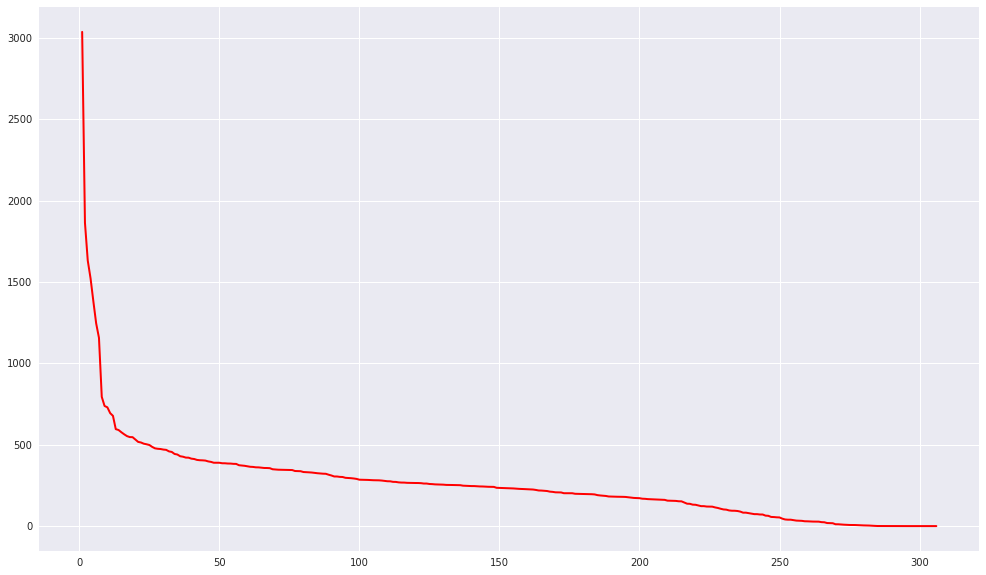

In [0]:
plt.figure(figsize=(15,10))
plt.plot(features['rank'],features['importance'],color="red",linewidth=2)

In [0]:
feature_filter=list(features.loc[(features['rank']<=187)]['feature'])
feature_filter.append('企业编号')

In [0]:
x_filter=x[list(feature_filter)]
x_filter

,软著数量,发明授权,实用新型,外观设计,发明公布,商标数量,资质证书数量,行业大类_C,作品著作数量,成立年数,...,摊薄总资产收益率(%)_min,净利率(%)_mean,资产:资产总计(元)_min,每股经营现金流(元)_max,负债:负债合计(元)_max,财务费用(元)_max,投资流出_mean,加权净资产收益率(%)_mean,投资流出_max,企业编号
0,1.0,0.0,0.0,0.0,4.0,255.0,9.0,0.0,1.0,14.0,...,0.0024,0.343078,0.418085,-1.6600,10.002016,1.950526e+08,3.173491e+12,0.097644,4.768984e+12,1001
1,2.0,0.0,1.0,0.0,1.0,5.0,0.0,0.0,0.0,13.0,...,0.0190,0.227522,16.642118,1.7009,140.656871,7.248514e+07,1.865108e+09,0.078367,4.084310e+09,1002
2,2.0,61.0,955.0,469.0,141.0,90.0,442.0,1.0,0.0,24.0,...,-0.0078,0.015733,-24.609220,0.3714,28.259997,-3.211562e+06,3.602564e+09,0.030111,5.645571e+09,1003
3,0.0,0.0,1.0,5.0,1.0,6.0,1.0,0.0,6.0,17.0,...,0.0139,0.261311,-2.714605,1.1968,11.256137,1.415579e+08,1.273136e+09,0.071667,2.377073e+09,1004
4,6.0,2.0,6.0,0.0,6.0,17.0,5.0,0.0,0.0,20.0,...,0.0023,0.073122,19.680974,0.6137,40.738386,9.116558e+08,5.613110e+09,0.034333,8.845762e+09,1005
5,2.0,5.0,8.0,2.0,12.0,5.0,6.0,0.0,1.0,19.0,...,0.0304,0.460989,1.124474,2.1350,10.928766,-4.530856e+07,1.944693e+09,0.093338,2.977211e+09,1006
6,0.0,269.0,836.0,2.0,962.0,8.0,7.0,1.0,0.0,19.0,...,0.0006,0.031044,1.595949,0.1984,3.305182,1.854352e+09,7.738014e+08,0.020033,1.836114e+09,1007
7,0.0,79.0,218.0,0.0,242.0,20.0,1.0,0.0,0.0,16.0,...,0.0028,0.045956,-0.253721,2.0730,44.984566,9.405739e+09,1.951729e+10,0.041922,3.948164e+10,1008
8,0.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,23.0,...,0.0185,0.376922,5.913169,1.1352,12.033064,4.234151e+07,8.979506e+08,0.075056,1.649485e+09,1009
9,0.0,2.0,0.0,1.0,16.0,129.0,0.0,0.0,0.0,14.0,...,0.0018,0.295967,5.947799,13.0930,7.455572,1.950526e+08,6.078777e+11,0.086044,8.751980e+11,1010


In [0]:
xtrain_filter, xtest_filter, ytrain, ytest = train_test_split(
    x_filter, y, test_size=0.2, random_state=0)
ytrain_id = ytrain['企业编号']
ytrain = ytrain['企业总评分']
ytest_id = ytest['企业编号']
ytest = ytest['企业总评分']
print(xtrain_filter.shape, xtest_filter.shape, ytrain.shape, ytest.shape)

id_train = xtrain_filter['企业编号']
id_test = xtest_filter['企业编号']
xtrain_filter.drop(['企业编号'], axis=1, inplace=True)
xtest_filter.drop(['企业编号'], axis=1, inplace=True)

(2364, 188) (592, 188) (2364,) (592,)


In [0]:
params = {
    # objective and metric
    "objective": "regression",
    "metric": 'rmse',
    "boosting": "gbdt",

    # for the Leaf-wise (Best-first) Tree
    "num_leaves": 120, 
    # smaller than 2^(max_depth), This is the main parameter to control the complexity of the tree model. With larger can get higher accuracy 
    "min_data_in_leaf": 20, # Setting it to a large value can avoid growing too deep a tree, but may cause under-fitting.
    "max_depth": 7, # limit the tree depth explicitly.

    # For Faster Speed
    "bagging_fraction": 0.7,
    "bagging_freq": 1,
#     "max_bin": 5, # more small more faster
    "bagging_seed": 11,

    # For Better Accuracy
    "max_bin": 30, # lager but slower
    "learning_rate": 0.005,

    # deal with over fitting
      # Use small max_bin
      # Use small num_leaves
      # Use min_data_in_leaf and min_sum_hessian_in_leaf
      # Use bagging by set bagging_fraction and bagging_freq
      # Use feature sub-sampling by set feature_fraction
      # Use bigger training data
      # Try lambda_l1, lambda_l2 and min_gain_to_split for regularization
      # Try max_depth to avoid growing deep tree
    "feature_fraction": 0.8,
    "lambda_l1": 0.1,

    "min_child_samples": 100,

    # other
    "n_estimators": 1500, # num_itertations的别名，默认是100.也就是循环次数，或者叫树的数目
    "verbosity": -1,
    "n_jobs":8,
}
models, feature_importance_df = train_lgbm(xtrain_filter, ytrain, xtest_filter, ytest, params)

----
fold n°0
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.27283	valid_1's rmse: 2.97459
[1000]	training's rmse: 1.69521	valid_1's rmse: 2.92697
Early stopping, best iteration is:
[1124]	training's rmse: 1.5867	valid_1's rmse: 2.92481
----
fold n°1
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.25937	valid_1's rmse: 3.29271
Early stopping, best iteration is:
[836]	training's rmse: 1.81141	valid_1's rmse: 3.23493
----
fold n°2
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.28011	valid_1's rmse: 3.06421
Early stopping, best iteration is:
[849]	training's rmse: 1.83199	valid_1's rmse: 3.02137
----
fold n°3
Training until validation scores don't improve for 150 rounds.
[500]	training's rmse: 2.25778	valid_1's rmse: 3.29559
[1000]	training's rmse: 1.67113	valid_1's rmse: 3.20162
Early stopping, best iteration is:
[1177]	training's rmse: 1.52116	valid_1's rmse: 3.19817